In [1]:
import numpy as np

In [2]:
#import numpy as np
def bhmie(x,refrel,nang):
  # Calculation based on Mie scattering theory  
  # input:
  #      x      - size parameter = k*radius = 2pi/lambda * radius   
  #                   (lambda is the wavelength in the medium around the scatterers)
  #      refrel - refraction index (n in complex form for example:  1.5+0.02*i;
  #      nang   - number of angles for S1 and S2 function in range from to pi/2
  # output:
  #        S1, S2 - funtion which correspond to the (complex) phase functions
  #        Qext   - extinction efficiency
   17 #        Qsca   - scattering efficiency 
   18 #        Qback  - backscatter efficiency
   19 #        gsca   - asymmetry parameter
 

   nmxx=150000
     #fortranを探す matlabも
   # Require NANG>1 in order to calculate scattering intensities
   if (nang < 2):
       nang = 2

   s1_1=np.zeros(nang,dtype=np.complex128)
   s1_2=np.zeros(nang,dtype=np.complex128)
   s2_1=np.zeros(nang,dtype=np.complex128)
   s2_2=np.zeros(nang,dtype=np.complex128)
   pi=np.zeros(nang,dtype=np.complex128)
   tau=np.zeros(nang,dtype=np.complex128)

   if (nang > 1000):
       print ('error: nang > mxnang=1000 in bhmie')
       return

   pii = 4.*np.arctan(1.)#3.1415....
   dx = x

   drefrl = refrel
   y = x*drefrl
   ymod = abs(y)


   #    Series expansion terminated after NSTOP terms
   #    Logarithmic derivatives calculated from NMX on down

   xstop = x + 4.*x**0.3333 + 2.0
   #xstop = x + 4.*x**0.3333 + 10.0
   #print(f"xstop,ymod={xstop,ymod} and type of xstop,ymod={type(xstop),type(ymod)}")
   nmx = max(xstop,ymod) + 15.0
   nmx=np.fix(nmx)

   # BTD experiment 91/1/15: add one more term to series and compare resu<s
   #      NMX=AMAX1(XSTOP,YMOD)+16
   # test: compute 7001 wavelengeths between .0001 and 1000 micron
   # for a=1.0micron SiC grain.  When NMX increased by 1, only a single
   # computed number changed (out of 4*7001) and it only changed by 1/8387
    # conclusion: we are indeed retaining enough terms in series!

   nstop = int(xstop)

   if (nmx > nmxx):
       print ( "error: nmx > nmxx=%f for |m|x=%f" % ( nmxx, ymod) )
       return

   dang = .5*pii/ (nang-1)
   #print(f"nmx={nmx}.dx={dx}")
 
   amu=np.arange(0.0,nang,1)
   #print(pii,dang,amu*dang)
   amu=np.cos(amu*dang)
   #print(amu)
   pi0=np.zeros(nang,dtype=np.complex128)
   pi1=np.ones(nang,dtype=np.complex128)

   # Logarithmic derivative D(J) calculated by downward recurrence
   # beginning with initial value (0.,0.) at J=NMX

   nn = int(nmx)-1
   d=np.zeros(nn+1,dtype=np.complex128)
   for n in range(0,nn):
       en = nmx - n
       d[nn-n-1] = (en/y) - (1./ (d[nn-n]+en/y))
   #print(f"d={d}")

   #*** Riccati-Bessel functions with np.real argument X
   #    calculated by upward recurrence

   psi0 = np.cos(dx)
   psi1 = np.sin(dx)
   chi0 = -np.sin(dx)
   chi1 = np.cos(dx)
   xi1 = psi1-chi1*1j
   qsca = 0.
   gsca = 0.
   p = -1

   for n in range(0,nstop):
        en = n+1.0
        fn = (2.*en+1.)/(en* (en+1.))

   # for given N, PSI  = psi_n        CHI  = chi_n
   #              PSI1 = psi_{n-1}    CHI1 = chi_{n-1}
   #              PSI0 = psi_{n-2}    CHI0 = chi_{n-2}
   # Calculate psi_n and chi_n
        psi = (2.*en-1.)*psi1/dx - psi0
        chi = (2.*en-1.)*chi1/dx - chi0
        xi = psi-chi*1j
 
   #*** Store previous values of AN and BN for use
   #    in computation of g=<np.cos(theta)>
        if (n > 0):
           an1 = an
           bn1 = bn

   #*** Compute AN and BN:
        an = (d[n]/drefrl+en/dx)*psi - psi1
        an = an/ ((d[n]/drefrl+en/dx)*xi-xi1)
        bn = (drefrl*d[n]+en/dx)*psi - psi1
        bn = bn/ ((drefrl*d[n]+en/dx)*xi-xi1)

   #*** Augment sums for Qsca and g=<np.cos(theta)>
        qsca += (2.*en+1.)* (abs(an)**2+abs(bn)**2)
        gsca += ((2.*en+1.)/ (en* (en+1.)))*( np.real(an)* np.real(bn)+np.imag(an)*np.imag(bn))

        if (n > 0):
           gsca += ((en-1.)* (en+1.)/en)*( np.real(an1)* np.real(an)+np.imag(an1)*np.imag(an)+np.real(bn1)* np.real(bn)+np.imag(bn1)*np.imag(bn))

 
   #*** Now calculate scattering intensity pattern
   #    First do angles from to 90
        pi=0+pi1    # 0+pi1 because we want a hard copy of the values
        tau=en*amu*pi-(en+1.)*pi0
        #print(s1_1)
        s1_1 += fn* (an*pi+bn*tau)
        s2_1 += fn* (an*tau+bn*pi)

   #*** Now do angles greater than 90 using PI and TAU from
   #    angles less than 90.
    #    P=1 for N=1,3,...% P=-1 for N=2,4,...
   #   remember that we have to reverse the order of the elements
   #   of the second part of s1 and s2 after the calculation
        p = -p
        s1_2+= fn*p* (an*pi-bn*tau)
        s2_2+= fn*p* (bn*pi-an*tau)

        psi0 = psi1
        psi1 = psi
        chi0 = chi1
        chi1 = chi
        xi1 = psi1-chi1*1j

   #*** Compute pi_n for next value of n
   #    For each angle J, compute pi_n+1
   #    from PI = pi_n , PI0 = pi_n-1
        pi1 = ((2.*en+1.)*amu*pi- (en+1.)*pi0)/ en
        pi0 = 0+pi   # 0+pi because we want a hard copy of the values
        #print(f"pi0,pi1={pi0,pi1}")
   #*** Have summed sufficient terms.
    #    Now compute QSCA,QEXT,QBACK,and GSCA

   #   we have to reverse the order of the elements of the second part of s1 and s2
   
   s1=np.concatenate((s1_1,s1_2[-2::-1]))
   s2=np.concatenate((s2_1,s2_2[-2::-1]))
   gsca = 2.*gsca/qsca
   qsca = (2./ (dx*dx))*qsca
   qext = (4./ (dx*dx))* np.real(s1[0])

   # more common definition of the backscattering efficiency,
     # so that the backscattering cross section really
    # has dimension of length squared
   qback = 4*(abs(s1[2*nang-2])/dx)**2
#qback = ((abs(s1[2*nang-2])/dx)**2 )/pii  #old form

   return s1,s2,qext,qsca,qback,gsca

In [3]:
import matplotlib.pyplot as plt

In [40]:
#define parameter
x = 10000
refrel = 10 - 10*1j
nang = 30

In [ ]:
s1,s2,qext,qsca,qback,gsca = bhmie(x,refrel,nang)
print(f"qext={qext}, \nqsca={qsca}, \n qback={qback}")
s1_abs = np.abs(s1) ** 2

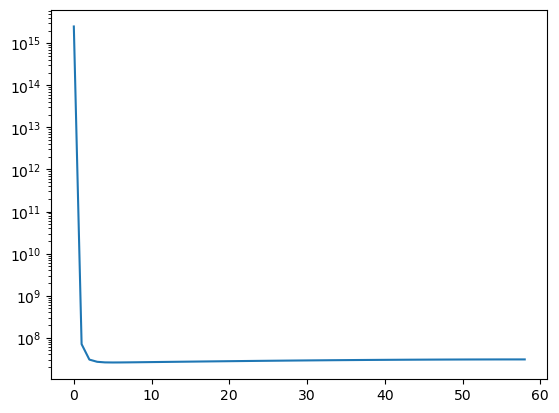

In [42]:
fig,ax = plt.subplots()
ax.plot(s1_abs)
#ax.set_ylim(0,10000000)
ax.set_yscale("log")
plt.show()

In [26]:
#test
array1 = np.array([1,2,3])
array2 = np.array([1,2,4])
array3 = array1*array2
print(array3)
print(np.cos(1.57))

[ 1  4 12]
0.0007963267107332633


### plot series

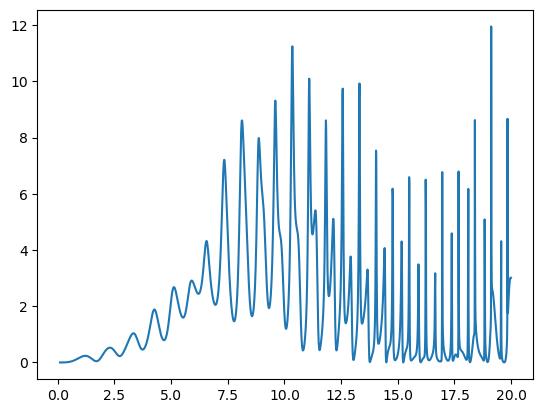

In [7]:


fig,ax = plt.subplots()
ax.plot(x,qback)
plt.show()

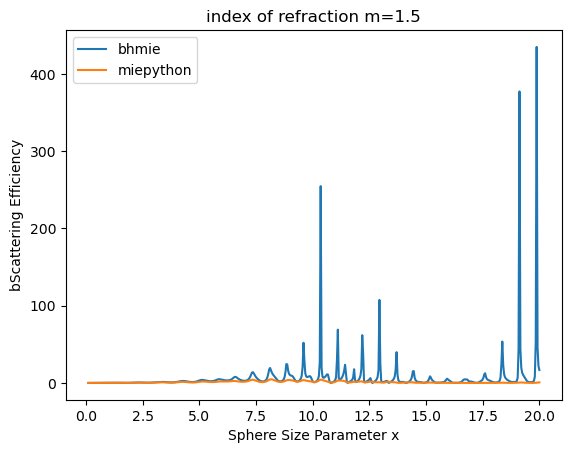

In [13]:
import miepython
N=500
refrel=1.5-0.01j
x = np.linspace(0.1,20,N)  # also in microns
#x = np.arange(0.1,20,0.01)
fig,ax = plt.subplots()
nang = 3
qback_bhmie = [bhmie(x,refrel,nang)[4] for x in x]
qext, qsca, qback, g = miepython.mie(refrel,x)
ax.plot(x,qback_bhmie,label="bhmie")
ax.plot(x,qback,label="miepython")
ax.legend()
plt.xlabel("Sphere Size Parameter x")
plt.ylabel("bScattering Efficiency")
plt.title("index of refraction m=1.5")
plt.show()